In [42]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [43]:
import sys
customized_path_to_homework = "/content/gdrive/My Drive/Research"
sys.path.append(customized_path_to_homework)

In [44]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from datetime import datetime as dt, timedelta
import warnings
import seaborn as sns
sys.path.insert(0,'../')
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Load data**

In [45]:
file_name = "cs4114_spring_2021"
data = pd.read_csv("/content/gdrive/My Drive/Research/" + file_name + "_merged_result_unannotated.csv")
data.loc[(data['Event name'] == 'Other event') & (data['Event Description'].str.contains("PE") == True) & (data['Number of events'] > 1), "Event name"] = "PE event"
sorted_data = pd.read_csv("/content/gdrive/My Drive/Research/" + file_name + "_sorted.csv")

pi_attempts = pd.read_csv("/content/gdrive/My Drive/Research/pi_attempts.csv")

users = data['user ID'].unique()
df_dict = {elem: pd.DataFrame for elem in users}
for user in df_dict.keys():
    df_dict[user] = data[:][data['user ID'] == user]

In [46]:
# drop students
data = data[(data['user ID'] != 6616) & (data['user ID'] != 58)]
sorted_data = sorted_data[(sorted_data['user_id'] != 6616) & (sorted_data['user_id'] != 58)]
data['user ID'].unique()

array([  812,  1270,  3041,  4622,  4679,  4800,  4918,  4922,  4934,
        4999,  5085,  5115,  5137,  5168,  5230,  5671,  6494,  6523,
        6536,  6545,  6555,  6559,  6572,  6582,  6590,  6658,  6660,
        6682,  6688,  6701,  6704,  6707,  6724,  6819,  6859,  6866,
        6881,  6884,  6885,  6900,  6921,  7265,  7510,  7523,  7537,
        7548,  7582,  7607,  7619,  7666,  7676,  7713,  7723,  7724,
        7734,  7756,  7778,  7952,  7957,  7981,  7986,  8009,  8045,
        8070,  8130,  8556,  8828,  8900,  8984,  9203,  9306, 10174,
       11604, 12467, 13690, 13695])

Number of rows for raw data & abstracted data

In [47]:
data.groupby('user ID')['session'].max()

user ID
812      42
1270     33
3041     13
4622     73
4679     39
         ..
10174     2
11604     4
12467    33
13690    11
13695    37
Name: session, Length: 76, dtype: int64

In [48]:
print("Number of rows for raw data: {}".format(len(data.index)))
print("Number of rows for abstracted data: {}".format(len(sorted_data.index)))
print("Number of sessions: {}".format(data.groupby('user ID')['session'].max().sum()))

Number of rows for raw data: 126412
Number of rows for abstracted data: 1638155
Number of sessions: 3490


Top 10 most used frames (Based on number of each frame event counts)

In [49]:
frames_df = sorted_data[((sorted_data['name'] == 'jsav-forward') | (sorted_data['name'] == 'jsav-backward') | (sorted_data['name'] == 'jsav-begin') | (sorted_data['name'] == 'jsav-end')) & (sorted_data['ex_type'] != 'pe')] 
# frames_df = frames_df[frames_df['action_time'] != frames_df['action_time']]
frames_df['description'] = frames_df['description'].str.replace('{|}|"','')
frames_df[['ev_num','current','total']] = frames_df['description'].str.split(',',expand=True)
frames_df['current'] = frames_df['current'].str.replace('currentStep:','')
frames_df['total'] = frames_df['total'].str.replace('totalSteps:','')
frames_df['current'] = frames_df['current'].astype(int)
frames_df['total'] = frames_df['total'].astype(int)
frames_df = frames_df.sort_values(['action_time', 'current'])
frames_df = frames_df.drop_duplicates(subset=['action_time', 'short_name'], keep=False)
#frames_df = frames_df[~frames_df[['action_time', 'short_name']].duplicated() | ~frames_df['name'].eq('jsav-forward')]

In [50]:
# top_frames = frames_df[['short_name','user_id']].groupby(['short_name'])['user_id'].count().reset_index(name='count').sort_values(['count'], ascending=False)
top_frames = frames_df['short_name'].value_counts()
top_10_frames = top_frames.head(10).index.tolist()
top_10_frames

['LanguagesFS',
 'TMGeneralModel',
 'TravelSalesman',
 'PLExample1FF',
 'CFGDerivationsFF',
 'GrammarIntroFS',
 'PDACFLFF',
 'PDAAcceptanceEquivalenceFF',
 'LeftLinearGrammarFF',
 'UnsolveableProblems1']

In [51]:
# Only select frames data
frames = data[(data['Event name'] == 'FF event')]
frames['Action Time'] = frames["Action Time"].str.replace('.0 seconds', '').astype(int)
# Calculate total time and total event for each student
totalTime = frames[(frames['Action Time'] > 0) & (frames['Action Time'] < 600)].groupby('user ID')['Action Time'].sum()
totalEvent = frames[(frames['Action Time'] > 0) & (frames['Action Time'] < 600)].groupby('user ID')['Number of events'].sum()
avg_time_spent_per_user = totalTime / totalEvent
user_count = totalTime.count()

Bar chart - sorted by avgerage time spent on one slide (in top 10 frameset)

Average time (in sec) spend per slide: 2.8514920000964525 seconds


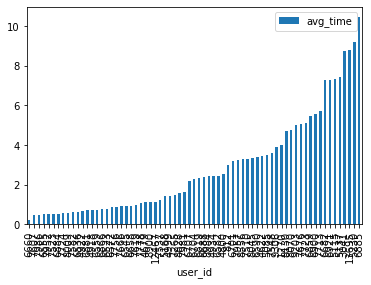

In [52]:
ax = pd.DataFrame(avg_time_spent_per_user.items(), columns=['user_id', 'avg_time']).sort_values('avg_time')
ax.plot.bar(x='user_id', y='avg_time', rot=90)

print("Average time (in sec) spend per slide: {} seconds".format(avg_time_spent_per_user.sum() / user_count))

In [53]:
sorted_dict = sorted_data.to_dict('records')

In [54]:
d = {}
forward_count = 0
backward_count = 0
user = sorted_dict[0]['user_id']
for row in sorted_dict:
  if user not in d:
    d[user] = {}
  if user != row['user_id']:
    d[user]['forward'] = forward_count
    d[user]['backward'] = backward_count
    forward_count = 0
    backward_count = 0
    user = row['user_id']
  if row['name'] == 'jsav-forward':
    forward_count += 1
  elif row['name'] == 'jsav-backward':
    backward_count += 1
d[user]['forward'] = forward_count
d[user]['backward'] = backward_count

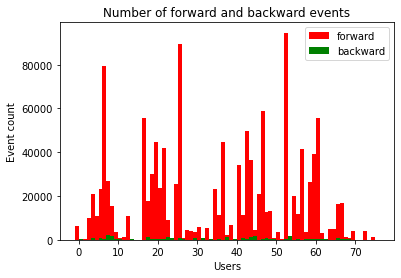

Average forward event per student: 16554.0
Average backward event per student: 373.07894736842104


In [55]:
names = list(d.keys())
f = [ x['forward'] for x in d.values() ] 
b = [ x['backward'] for x in d.values() ] 
plt.bar(np.arange(len(d)) - 0.5, f, 1, color='red', label='forward')
plt.bar(np.arange(len(d)) + 0.5, b, 1, color='green', label='backward')
plt.plot()
plt.xlabel("Users")
plt.ylabel("Event count")
plt.title("Number of forward and backward events")
plt.legend()
plt.show()
print("Average forward event per student: {}".format(np.sum(f) / len(d)))
print("Average backward event per student: {}".format(np.sum(b) / len(d)))

count    23475.000000
mean        21.488349
std        112.320933
min          1.000000
25%          1.000000
50%          3.000000
75%          9.000000
max       3574.000000
Name: Action Time, dtype: float64


Text(0, 0.5, 'Number of Instances')

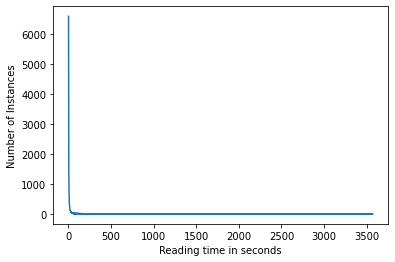

In [56]:
temp = data[data['Action Time'].str.contains('Reading time') == True]
temp['Action Time'] = temp['Action Time'].str[13:-3].astype(float)
temp2 = temp[ (temp['Action Time'] > 0) & (temp['Action Time'] < 4000) ]
temp2
#df['col'] = df['col'].str[:9]
print(temp2['Action Time'].describe())
p = temp2['Action Time'].value_counts().plot(x="Action Time", y="Count")
p.set_xlabel("Reading time in seconds")
p.set_ylabel("Number of Instances")
#data.head(10)

Histogram of idle time (Session threshold reason)


1.   Delta times between consecutive events


---



count    4.438740e+05
mean     1.470614e+03
std      4.534873e+04
min      1.000000e+00
25%      1.000000e+00
50%      4.000000e+00
75%      1.000000e+01
max      7.860744e+06
Name: delta_time, dtype: float64

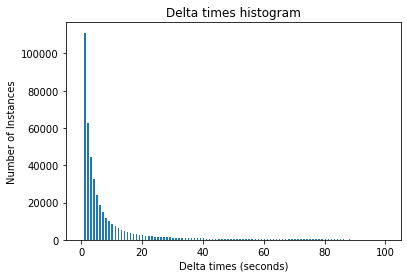

In [57]:
sorted_data['action_time'] = pd.to_datetime(sorted_data['action_time']) 
sorted_data['delta_time'] = sorted_data.groupby('user_id')['action_time'].diff()
sorted_data['delta_time'] = sorted_data['delta_time'].dt.total_seconds()
temp_sorted_data = sorted_data
temp_sorted_data = temp_sorted_data[ (temp_sorted_data['delta_time'] > 0)]
p = temp_sorted_data['delta_time'].plot.hist(bins= 200, range=(0, 100))

p.set_xlabel("Delta times (seconds)")
p.set_ylabel("Number of Instances")
p.set_title("Delta times histogram")
temp_sorted_data['delta_time'].describe()

Behavior 4 PI Credit Seeking

In [58]:
behavior4 = frames_df
behavior4['action_time'] = pd.to_datetime(behavior4['action_time'])
behavior4['delta_time'] = behavior4.groupby('user_id')['action_time'].diff()
behavior4['delta_time'] = behavior4['delta_time'].dt.total_seconds()
total_frames_event = behavior4.groupby('user_id')['id'].count()


credit_seeking_event = behavior4.groupby('user_id')['delta_time'].apply(lambda x: (x <= 8).sum()).reset_index(name='count')

behavior4.groupby('user_id')['id'].agg(['count'])

,count
user_id,
812,2055
1270,148
3041,193
4622,2889
4679,1802
...,...
9306,1407
10174,1
11604,3


In [59]:
print("======== Total PIFrames Credit Seeking related event number=======")
behavior4.groupby('user_id')['delta_time'].apply(lambda x: (x <= 8).sum()).reset_index(name='count')

======== Total PIFrames Credit Seeking related event number=======


,user_id,count
0,812,1488
1,1270,72
2,3041,78
3,4622,1516
4,4679,1301
...,...,...
66,9306,937
67,10174,0
68,11604,1
69,12467,483
